<a href="https://colab.research.google.com/github/marquesbmc/Artificial-Intelligence/blob/main/grid2d_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Library and packages*

In [1]:
!pip install gym
!pip install --upgrade ipython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.6/806.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.15.0 which is incompatible.


# *Environment*

In [33]:
import numpy as np
import itertools
from skimage.transform import resize
import matplotlib.pyplot as plt
import gym
from gym import spaces

class Grid2DObject(object):
    def __init__(self, coordinates, size, intensity, channel, reward, name):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name

class Grid2DEnv(gym.Env):
    def __init__(self, partial=True, sizeX=10, sizeY=10):
        super(Grid2DEnv, self).__init__()

        self.sizeX = sizeX
        self.sizeY = sizeY
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84, 3), dtype=np.uint8)
        self.channel = 3
        self.partial = partial
        self.radar = 7
        self.objects = []
        self.state_full = self.reset()

    def _newPosition(self, occupied_positions):
        iterables = [range(self.sizeX), range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        for pos in occupied_positions:
            if pos in points:
                points.remove(pos)
        location = np.random.choice(range(len(points)), replace=False)
        return points[location]

    def reset(self):
        self.objects = []
        occupied_positions = []
        state_full = None
        rgb_channel = self.channel

        matrix_G = np.zeros([self.sizeX, self.sizeY, rgb_channel])

        agent_pos = self._newPosition(occupied_positions)
        agent = Grid2DObject([2,2], 1, 1, 2, None, 'agent')
        occupied_positions.append((2,2)) # Adicionando a posição do agent
        self.objects.append(agent)

        num_goals = 2
        for _ in range(num_goals):
            goal_pos = self._newPosition(occupied_positions)
            goal_obj = Grid2DObject(goal_pos, 1, 1, 1, 1, 'goal')
            self.objects.append(goal_obj)
            occupied_positions.append(goal_pos)

        for _ in range(3):
            fire_pos = self._newPosition(occupied_positions)
            fire_obj = Grid2DObject(fire_pos, 1, 1, 0, -1, 'fire')
            self.objects.append(fire_obj)
            occupied_positions.append(fire_pos)



        for item in self.objects:
            matrix_G[item.x, item.y, item.channel] = item.intensity * 255
        self.state_full = matrix_G

        return matrix_G

    def step(self, agent, action):
        penalty = self.moveChar(agent, action)
        reward, done = self.checkGoal(agent)
        state_full = self._render_full()
        state = self.render(agent)
        return state, (reward + penalty), done, {}

    def render(self, agent):
        if isinstance(agent, Grid2DObject):
            state = self._get_cut_around(self.state_full, agent.x, agent.y, self.radar)
        else:
            state = None
        return state

    def _search_agent(self):
        for o in env.objects:
            if o.name == 'agent':
                agent = o
                return agent
        return None

    def close(self):
        # Redefinir todos os atributos internos
        self.sizeX = None
        self.sizeY = None
        self.action_space = None
        self.observation_space = None
        self.channel = None
        self.partial = None
        self.radar = None
        self.objects = None
        self.state_full = None

    def moveChar(self, agent, direction):
        agentX = agent.x
        agentY = agent.y
        penalize = 0.0
        nextX, nextY = agent.x, agent.y
        if direction == 0 and agent.y >= 1:
            nextY -= 1
        elif direction == 1 and agent.y <= self.sizeY - 2:
            nextY += 1
        elif direction == 2 and agent.x >= 1:
            nextX -= 1
        elif direction == 3 and agent.x <= self.sizeX - 2:
            nextX += 1

        if nextX < 0 or nextX >= self.sizeX or nextY < 0 or nextY >= self.sizeY:
            penalize += -0.1
            nextX, nextY = agent.x, agent.y

        elif any(obj.name == 'goal' and obj.x == nextX and obj.y == nextY for obj in self.objects):
            penalize += 0.1
            nextX, nextY = agent.x, agent.y

        elif any(obj.name == 'fire' and obj.x == nextX and obj.y == nextY for obj in self.objects):
            penalize += -0.1
            nextX, nextY = agent.x, agent.y

        agent.x, agent.y = nextX, nextY

        return penalize

    def checkGoal(self, agent):
        goals = [obj for obj in self.objects if obj.name == 'goal']
        for goal in goals:
            if abs(agent.x - goal.x) <= 1 and abs(agent.y - goal.y) <= 1:
                return 1.0, True
        fires = [obj for obj in self.objects if obj.name == 'fire']
        for fire in fires:
            if abs(agent.x - fire.x) <= 1 and abs(agent.y - fire.y) <= 1:
                return -1.0, False
        return 0.0, False

    def _render_full(self):
        matrix_G = np.zeros([self.sizeX, self.sizeY, self.channel])
        for item in self.objects:
            matrix_G[item.x, item.y, item.channel] = item.intensity * 255
        self.state_full = matrix_G
        return matrix_G

    def _get_cut_around(self, matrix, lin, col, length):
        n, m, channels = len(matrix), len(matrix[0]), len(matrix[0][0])
        matrix_cut = [[[0 for k in range(channels)] for j in range(length)] for i in range(length)]
        offset = length // 2
        for i in range(-offset, offset + 1):
            for j in range(-offset, offset + 1):
                for k in range(channels):
                    if 0 <= lin + i < n and 0 <= col + j < m:
                        matrix_cut[i + offset][j + offset][k] = matrix[lin + i][col + j][k]
                    else:
                        matrix_cut[i + offset][j + offset][k] = 1 * 255
        return matrix_cut

In [9]:
import matplotlib.pyplot as plt

def plot(state):
    if isinstance(state, list):
        state = np.array(state)

    if len(state.shape) == 2:
        cmap = 'gray'
    else:
        cmap = None

    if state.dtype in [np.float32, np.float64]:
        state = np.clip(state, 0, 1)
    else:
        state = np.clip(state, 0, 255).astype(np.uint8)


    plt.imshow(state, cmap=cmap)
    return plt.show()

def plot_parallel(img1, img2, title1="Full View", title2="Partial View"):
    """Plota duas imagens lado a lado."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.imshow(img1, cmap='gray')
    ax1.set_title(title1)
    ax1.axis('off')

    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

# *Image pre processing*

In [38]:
from skimage.transform import resize

def preprocess_for_nn(image, target_size=(84, 84)):
    """Preprocesses the image for use in a neural network."""

    def ensure_numpy_array(input_data):
        if isinstance(input_data, np.ndarray):
            return input_data
        else:
            try:
                return np.array(input_data)
            except Exception as e:
                raise ValueError(f"Unable to convert input to a numpy array. Error: {e}")

    def preprocess_image(matrix, target_size=(84, 84)):
        grid_nxn = ensure_numpy_array(matrix)
        grid_nxn = resize(np.array(grid_nxn), target_size, order=0, anti_aliasing=True, mode='constant')
        return grid_nxn

    def rgb_to_gray(rgb_image):
        if len(rgb_image.shape) != 3 or rgb_image.shape[2] != 3:
            raise ValueError("The input must be an RGB image with dimensions (height, width, 3).")
        gray = 0.2989 * rgb_image[:, :, 0] + 0.5870 * rgb_image[:, :, 1] + 0.1140 * rgb_image[:, :, 2]
        return gray.astype(np.uint8)

    def normalize(image):
        if 1 < image.max() <= 255:
            return image / 255.0
        return image

    image = ensure_numpy_array(image)
    image = preprocess_image(image, target_size=target_size)
    image = rgb_to_gray(image)
    image = normalize(image)

    return image

#processed_image = preprocess_for_nn(original_image, target_size=(84, 84))

# *Deep Learning*

In [32]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, LSTM, GRU, Concatenate, Conv2D, Flatten, TimeDistributed, Lambda
import keras.backend as K
from keras.utils import to_categorical

class Qnetwork():
    def __init__(self, id_dim, timesteps, height, width, num_channels):

        self.id_dim = id_dim
        self.timesteps = timesteps
        self.height = height
        self.width = width
        self.num_channels = num_channels
        self.build_model()

    def build_model(self):
        # Definição das dimensões de entrada
        input_shape = (self.timesteps, self.height, self.width, self.num_channels)

        # Entradas
        observation_input = Input(shape=input_shape, name="observation_input")
        agent_id_input = Input(shape=(self.id_dim,), name="agent_id_input")

        # Camada Linear para ID
        id_embedding = Dense(128, activation="relu")(agent_id_input)

        # Camadas Convolucionais para a Observação
        conv1 = TimeDistributed(Conv2D(32, (3, 3), activation="relu"))(observation_input)
        conv2 = TimeDistributed(Conv2D(64, (3, 3), activation="relu"))(conv1)
        flattened = TimeDistributed(Flatten())(conv2)

        print(flattened.shape)

        # Concatenação da Observação e ID
        # Repetindo a ID incorporada para cada timestep
        id_embedding_repeated = Lambda(lambda x: K.repeat(x, self.timesteps))(id_embedding)
        concatenated = Concatenate(axis=-1)([flattened, id_embedding_repeated])

        # LSTM
        lstm_out = GRU(128)(concatenated)

        # Camada de Saída (por simplicidade, vamos assumir 4 ações possíveis: cima, baixo, esquerda, direita)
        output = Dense(4, activation="softmax")(lstm_out)

        # Modelo
        self.model = Model(inputs=[observation_input, agent_id_input], outputs=output)
        self.model.compile(optimizer="adam", loss="categorical_crossentropy")

    def summary(self):
        self.model.summary()



# *Buffer Experience*

In [7]:
from collections import deque, namedtuple


class ExperienceReplay:
    def __init__(self, buffer_size=50000):
        """
        Data structure used to hold game experiences.
        buffer_size: int : max number of experiences to store in the buffer
        """
        self.buffer = deque(maxlen=buffer_size)
        self.Experience = namedtuple("Experience", ["state", "action", "reward", "next_state", "done"])

    def add(self, experience):
        """
        Adds a single experience to the buffer.
        experience: tuple : a single experience
        """
        if len(experience) != 5:
            raise ValueError("Experience must be of form (state, action, reward, next_state, done)")

        exp = self.Experience(*experience)
        self.buffer.append(exp)

    def sample(self, size):
        if size > len(self.buffer):
            raise ValueError("Sample size exceeds buffer size.")
        sampled_experiences = random.sample(self.buffer, size)
        return sampled_experiences

        """
        def sample(self, size):

        Returns a sample of experiences from the buffer.
        size: int : number of experiences to sample

        if size > len(self.buffer):
            raise ValueError("Sample size exceeds buffer size.")

        sampled_experiences = np.random.choice(self.buffer, size, replace=False)
        return sampled_experiences
        """

# *Testes*

## Dumb choices

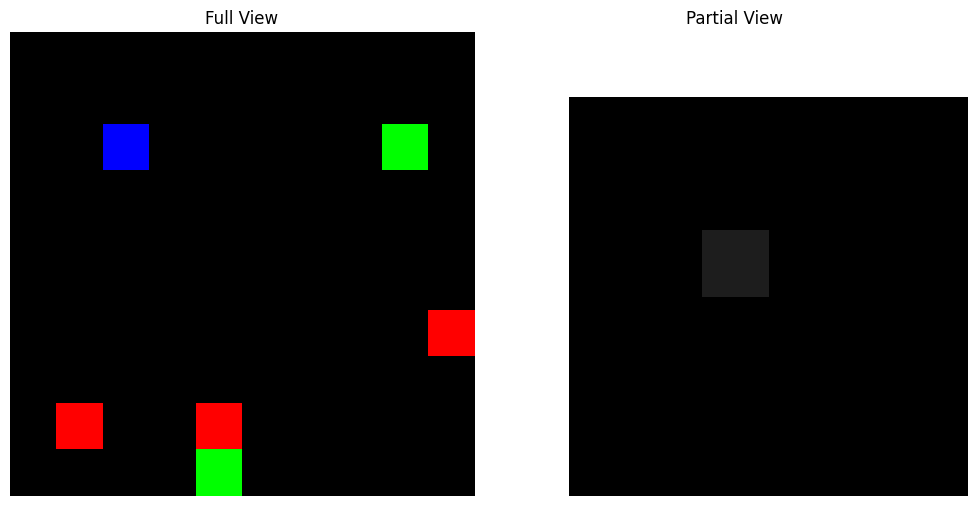

In [39]:
# Seu código original modificado
env = Grid2DEnv(sizeX=10, sizeY=10)
state_full = env.reset()

agent = env._search_agent()  # Pega a referência ao agente
partial_view = preprocess_for_nn(env.render(agent))  # Pega a visão parcial ao redor do agente

# Chama a função personalizada para plotar lado a lado
plot_parallel(state_full, partial_view)


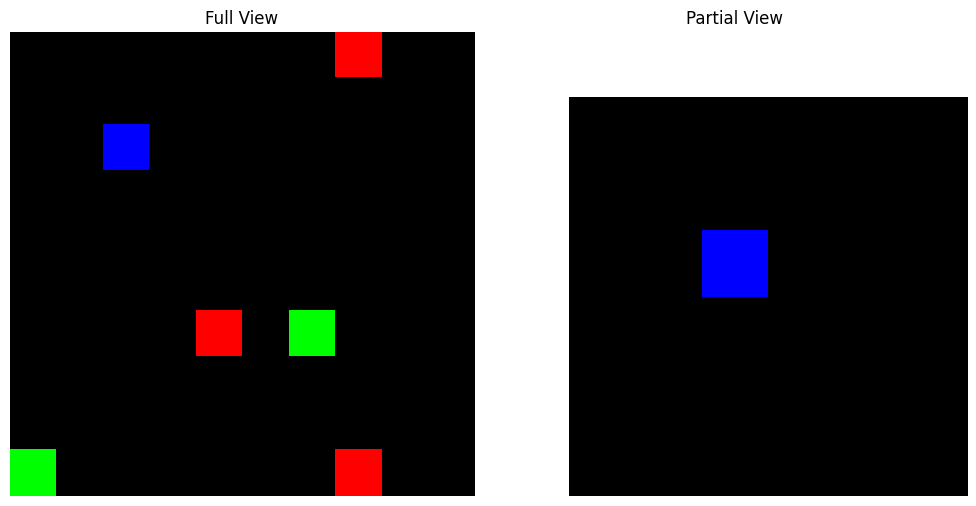

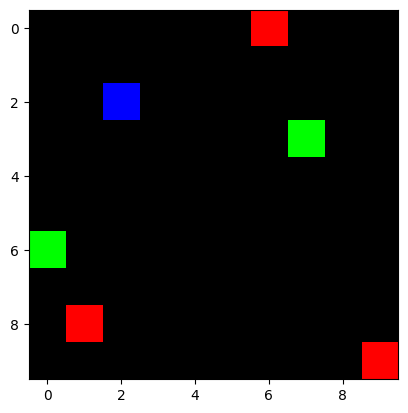

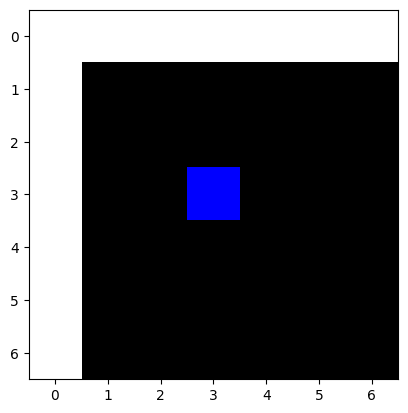

Episode 1 finished with total reward: 0


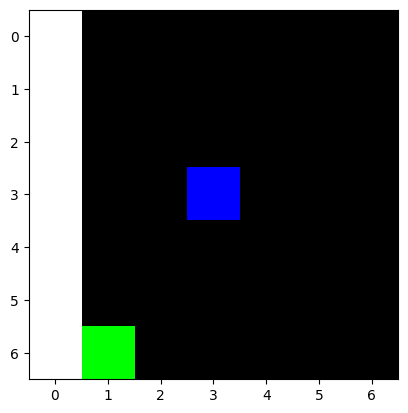

Episode 1 finished with total reward: 0


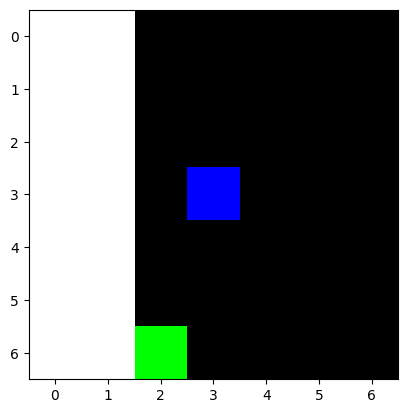

Episode 1 finished with total reward: 0


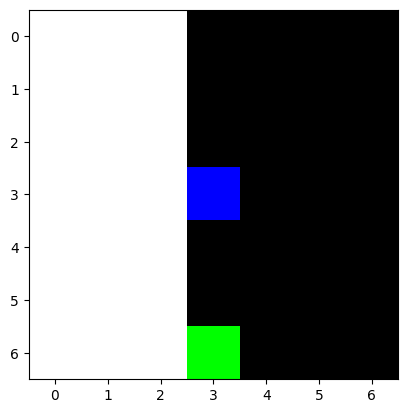

Episode 1 finished with total reward: 0


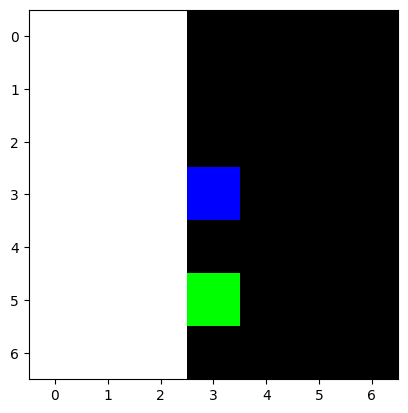

Episode 1 finished with total reward: 0


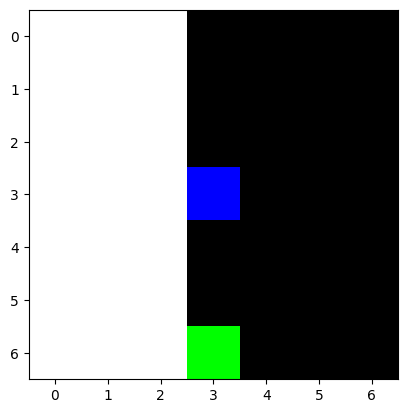

Episode 1 finished with total reward: 0


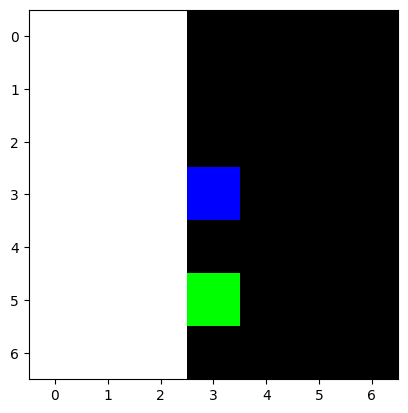

Episode 1 finished with total reward: 0


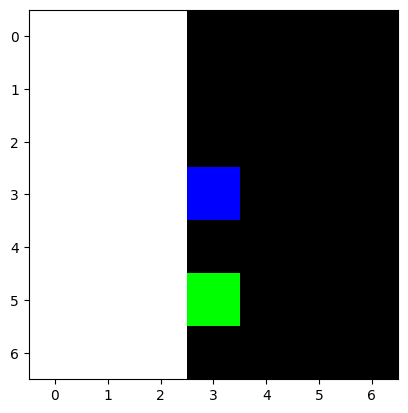

Episode 1 finished with total reward: 0


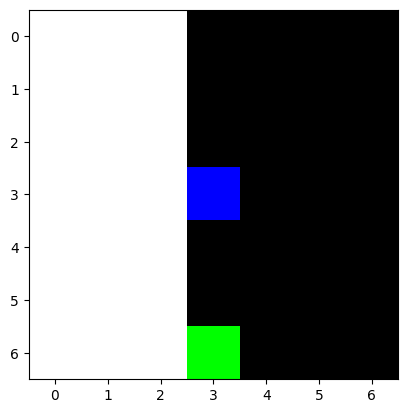

Episode 1 finished with total reward: 0


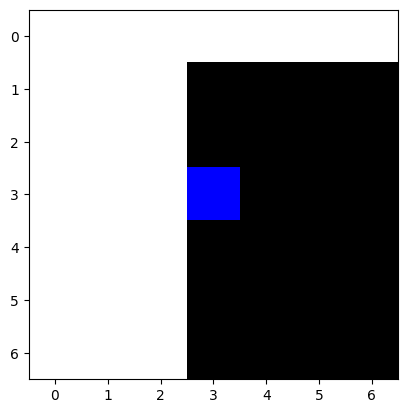

Episode 1 finished with total reward: 0


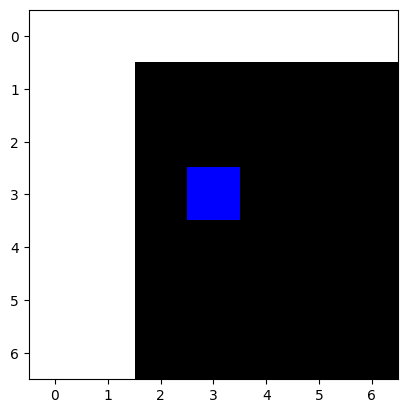

Episode 1 finished with total reward: 0


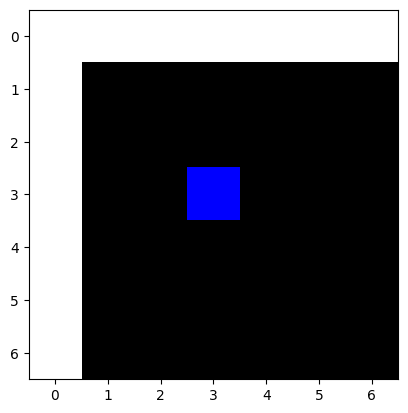

Episode 1 finished with total reward: 0


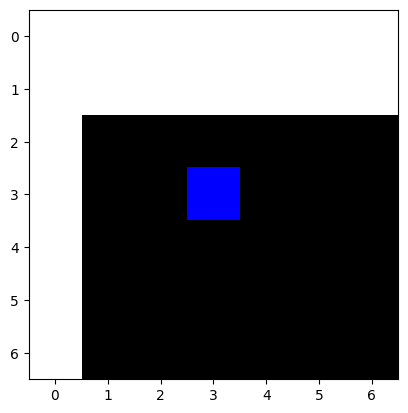

Episode 1 finished with total reward: 0


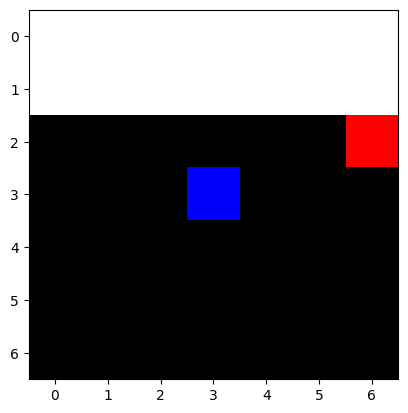

Episode 1 finished with total reward: 0


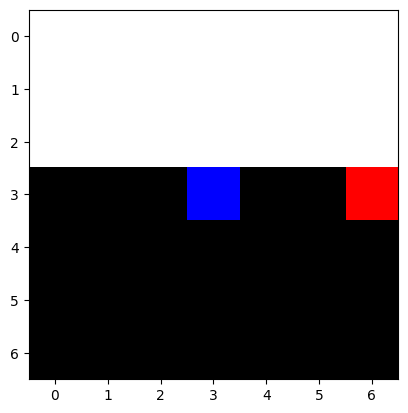

Episode 1 finished with total reward: 0


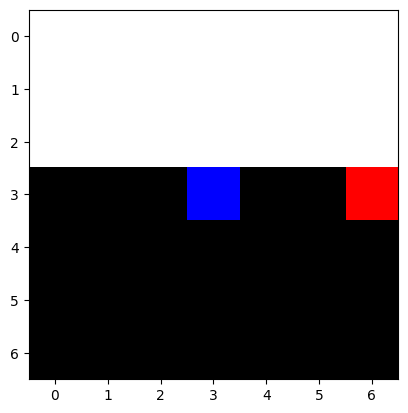

Episode 1 finished with total reward: 0


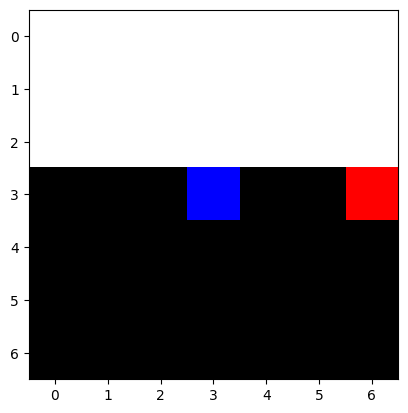

Episode 1 finished with total reward: 0


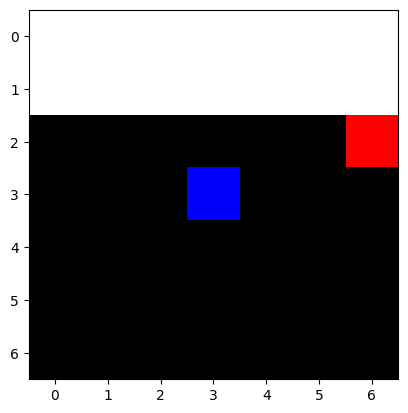

Episode 1 finished with total reward: 0


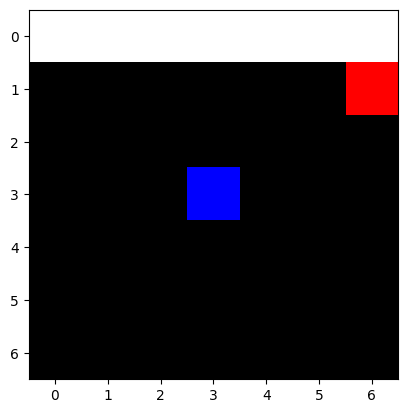

Episode 1 finished with total reward: 0


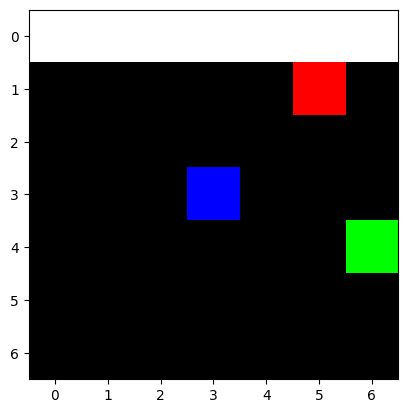

Episode 1 finished with total reward: 0


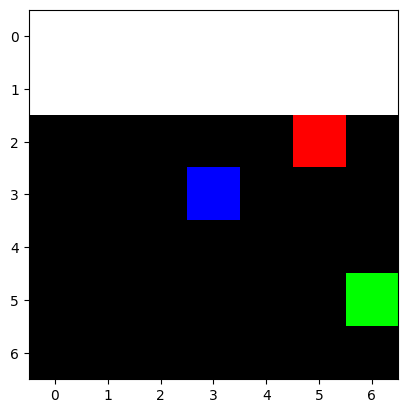

Episode 1 finished with total reward: 0


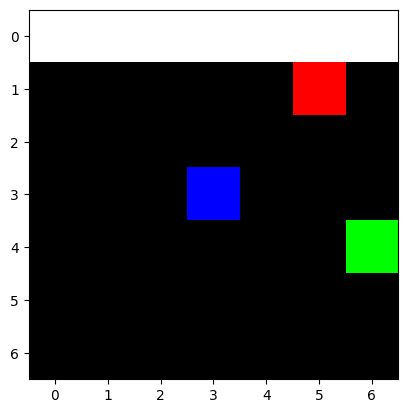

Episode 1 finished with total reward: 0


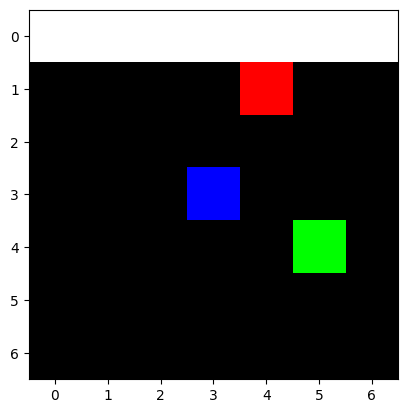

Episode 1 finished with total reward: 0


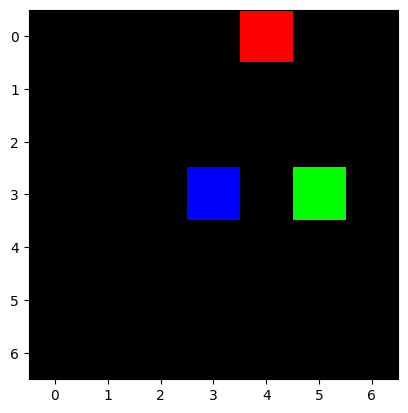

Episode 1 finished with total reward: 0


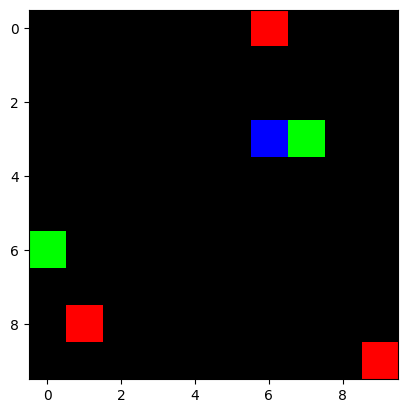

In [42]:
import tensorflow as tf
from skimage.transform import resize

# Seu código original modificado
env = Grid2DEnv(sizeX=10, sizeY=10)
state_full = env.reset()

agent = env._search_agent()  # Pega a referência ao agente
partial_view = env.render(agent)  # Pega a visão parcial ao redor do agente

# Chama a função personalizada para plotar lado a lado
plot_parallel(state_full, partial_view)

def teste():

    # Número de episódios para testar
    num_episodes = 1

    for episode in range(num_episodes):
        state_full = env.reset()
        plot(state_full)
        done = False
        total_reward = 0

        while not done:
            # Procura agent
            agent = env._search_agent()

            # Informa status parcial do agent apartir de uma agente e um state full do env
            state = env.render(agent)

            plot(state)

            # Escolha uma ação aleatória
            action = env.action_space.sample()

            # Execute a ação no ambiente
            next_state, reward, done, _ = env.step(agent, action)

            print(f"Episode {episode + 1} finished with total reward: {total_reward}")

    plot(env.state_full)
    env.close()

teste()

## Choices

In [ ]:
import tensorflow as tf
from skimage.transform import resize

# Seu código original modificado
env = Grid2DEnv(sizeX=10, sizeY=10)
state_full = env.reset()

agent = env._search_agent()  # Pega a referência ao agente
partial_view = env.render(agent)  # Pega a visão parcial ao redor do agente

# Chama a função personalizada para plotar lado a lado
plot_parallel(state_full, partial_view)

def teste():

    # Número de episódios para testar
    num_episodes = 1

    for episode in range(num_episodes):
        state_full = env.reset()
        plot(state_full)
        done = False
        total_reward = 0

        while not done:
            # Procura agent
            agent = env._search_agent()

            # Informa status parcial do agent apartir de uma agente e um state full do env
            state = env.render(agent)

            plot(state)

            # Escolha uma ação aleatória
            action = env.action_space.sample()

            # Execute a ação no ambiente
            next_state, reward, done, _ = env.step(agent, action)

            print(f"Episode {episode + 1} finished with total reward: {total_reward}")

    plot(env.state_full)
    env.close()

teste()

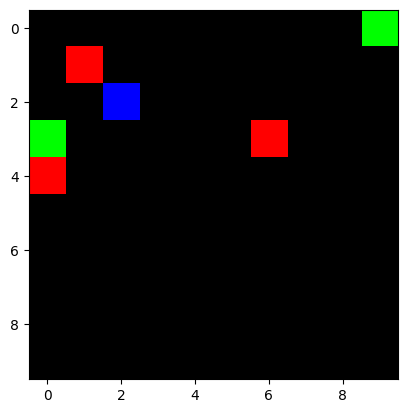

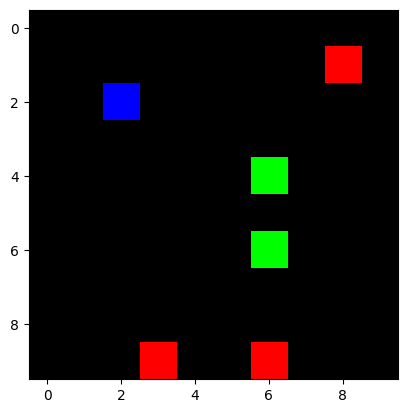

TypeError: ignored

In [43]:
import gym
from keras.utils import to_categorical
import numpy as np

def test_environment_dummy(episodes=10, steps=100):
    # Inicialize o ambiente e o buffer de repetição de experiência
    env = Grid2DEnv(sizeX=10, sizeY=10)

    #buffer = ExperienceReplay()

    for episode in range(episodes):
        state_full = env.reset()
        plot(state_full)



        for step in range(steps):
            done = False
            total_reward = 0

            state_full = env.reset()
            plot(state_full)

            agent = env._search_agent()
            state = env.render(agent)
            #state = preprocess_for_nn(state)
            plot(state)

            # Assumindo que o id do agente é simplesmente um vetor one-hot (por simplicidade)
            agent_id = to_categorical(0, num_classes=env.action_space.n)

            # Obter ação da rede neural (usando um agente aleatório por enquanto)
            action_probs = np.random.uniform(size=env.action_space.n)
            action = np.argmax(action_probs)

            # Realize a ação e obtenha o próximo estado, recompensa, etc.
            next_state, reward, done, _ = env.step(agent, action)
            next_state = preprocess_for_nn(next_state)

            # Armazene a experiência no buffer
            buffer.add((state, action, reward, next_state, done))

            state = next_state
            #plot(state)  # Se você quiser visualizar o estado, descomente esta linha
            total_reward += reward


            if done:
                break

            print(f"Episode {episode + 1} finished with reward: {total_reward}")

        print(f"Episode {episode + 1} finished with total reward: {total_reward}")

# Teste
test_environment_dummy()


In [ ]:
import gym
from keras.utils import to_categorical
import numpy as np

def test_environment_with_nn(episodes=10, steps=100, batch_size=32):
    env = Grid2DEnv()
    buffer = ExperienceReplay()

    # Inicializar a rede neural
    # Altere os parâmetros conforme necessário
    nn_agent = Qnetwork(num_channels=1, timesteps=1, height=84, width=84, id_dim=env.action_space.n)

    for episode in range(episodes):
        state_full = env.reset()
        done = False
        total_reward = 0

        agent = env._search_agent()
        state = env.render(agent)
        state = preprocess_for_nn(state)

        for step in range(steps):
            # Obter ação da rede neural
            agent_id = to_categorical(0, num_classes=env.action_space.n)
            action_probs = nn_agent.model.predict([np.expand_dims(state, 0), agent_id.reshape(1,-1)])
            action = np.argmax(action_probs[0])

            # Realize a ação e obtenha o próximo estado, recompensa, etc.
            next_state, reward, done, _ = env.step(agent, action)
            next_state = preprocess_for_nn(next_state)

            # Armazene a experiência no buffer
            buffer.add((state, action, reward, next_state, done))

            # Treine a rede neural com um lote de experiências (isso é um exemplo básico, você pode precisar ajustar)
            if len(buffer) > batch_size:
                experiences = buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*experiences)

                # Assuma que você tem uma função para gerar os targets Q apropriados
                q_targets = compute_q_targets(nn_agent, rewards, next_states, dones)

                agent_ids = to_categorical([0] * batch_size, num_classes=env.action_space.n)
                nn_agent.model.train_on_batch([np.array(states), agent_ids], q_targets)

            state = next_state
            total_reward += reward

            if done:
                break

        print(f"Episode {episode + 1} finished with total reward: {total_reward}")

# Teste
test_environment_with_nn()


In [ ]:
import random
import gym
from gym import spaces
from skimage.transform import resize
import itertools

env = Grid2DEnv(sizeX=10, sizeY=10)
qnetwork = Qnetwork(id_dim=1, timesteps=5, height=84, width=84, num_channels=1)
replay_buffer = ExperienceReplay()


# Running through some steps to fill replay buffer
for episode in range(10):

    # 1. Initialize the environment
    initial_state = env.reset()
    done = False
    total_reward = 0

    # 2. Search the agent object
    agent = env._search_agent()
    state = env.render(agent)
    state = preprocess_for_nn(state)

    # 3. Implement simple action mechanism
    num_episodes = 10
    num_steps = 50
    replay_buffer = ExperienceReplay()

    # 4. Create a Q-network
    qnetwork = Qnetwork(id_dim=1, timesteps=20, height=84, width=84, num_channels=3)
    qnetwork.summary()

    for episode in range(num_episodes):
        initial_state = env.reset()
        agent = env._search_agent()
        state = env.render(agent)
        state = preprocess_for_nn(state)
        state = np.expand_dims(state, axis=0)

        for step in range(num_steps):
            # For simplicity, use a random action
            action = random.choice([0, 1, 2, 3])

            next_state, reward, done, _ = env.step(agent, action)
            next_state = preprocess_for_nn(next_state)
            next_state = np.expand_dims(next_state, axis=0)

            replay_buffer.add((state, action, reward, next_state, done))

            state = next_state

            if done:
                break

    # 5. Sample from ExperienceReplay to see if it works
    sampled_experiences = replay_buffer.sample(10)
    for exp in sampled_experiences:
        print(exp)


In [ ]:
import gym
from gym import spaces

# Your classes (Grid2DObject, Grid2DEnv, etc.) here ...

# Initializing environment and agent
env = Grid2DEnv(sizeX=10, sizeY=10)
agent = Qnetwork(id_dim=1, timesteps=5, height=84, width=84, num_channels=1)
replay_buffer = ExperienceReplay()

# Running through some steps to fill replay buffer
for episode in range(10):
    state_initial = env.reset()
    agent = env._search_agent()
    state = env.render(agent)
    #state = preprocess_for_nn(state)
    done = False

    while not done:
        # Sample an action
        action = np.random.randint(0, 4)

        # Execute action in environment
        next_state, reward, done, _ = env.step(env._search_agent(), action)

        # Preprocess states for neural network
        processed_state = preprocess_for_nn(state)
        processed_next_state = preprocess_for_nn(next_state)

        # Save to replay buffer
        experience = (processed_state, action, reward, processed_next_state, done)
        replay_buffer.add(experience)

        # Move to next state
        state = next_state
        if done:
            break

# Sample from ExperienceReplay to see if it works
sampled_experiences = replay_buffer.sample(10)
for exp in sampled_experiences:
    print(exp)

In [ ]:
import numpy as np
import itertools
from skimage.transform import resize
import matplotlib.pyplot as plt
import gym
from gym import spaces

# Defina a classe Qnetwork aqui

# Defina a função para preprocessar observações
def preprocess_observation(observation):
    # Redimensione a observação para o tamanho esperado pela Qnetwork
    # Certifique-se de que a forma seja compatível com a da Qnetwork
    return resize(observation, (7, 7, 3), anti_aliasing=True).astype(np.uint8)

# Crie uma instância do ambiente Grid2DEnv
env = Grid2DEnv(sizeX=7, sizeY=7)

# Inicialize a Qnetwork com os parâmetros adequados
num_channels = 3  # O número de canais na observação do ambiente Grid2DEnv é 3
timesteps = 1  # Não estamos tratando de uma sequência temporal aqui, então timesteps = 1
height, width = 7, 7  # Redimensione a observação para 84x84
id_dim = 1  # Não estamos usando uma ID do agente neste ambiente

# Crie uma instância da Qnetwork
q_network = Qnetwork(num_channels, timesteps, height, width, id_dim)

# Defina alguns hiperparâmetros para treinamento
batch_size = 32
num_episodes = 1000
epsilon = 0.1  # Taxa de exploração

# Treine a Qnetwork
for episode in range(num_episodes):
    observation = env.reset()
    print(observation)
    done = False
    total_reward = 0

    while not done:
        # Pré-processamento da observação
        preprocessed_observation = preprocess_observation(observation)

        # Escolha uma ação usando a política epsilon-greedy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Ação aleatória (exploração)
        else:
            # Exploitação: escolha a ação com o maior valor Q
            q_values = q_network.model.predict([np.expand_dims(preprocessed_observation, axis=0)])
            action = np.argmax(q_values)

        # Execute a ação no ambiente
        next_observation, reward, done, _ = env.step(action)

        # Atualize a Qnetwork com a experiência
        # (implementação do treinamento da Qnetwork aqui)

        total_reward += reward
        observation = next_observation

    print(f"Episódio {episode + 1}: recompensa total = {total_reward}")

# Salve o modelo após o treinamento
q_network.model.save("modelo_treinado.h5")
